<a href="https://colab.research.google.com/github/tianiayu/UPB-Projects/blob/main/UAS_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install pyspark

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3099, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info. Did you mean: 'egg_info'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py",

In [1]:
# Import library yang diperlukan
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *

In [2]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName('SahamPrediction').getOrCreate()

In [3]:
# Definisikan schema kolom-kolom dengan tipe data yang sesuai
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adj Close", FloatType(), True),
    StructField("Volume", DoubleType(), True),
    # Tambahkan kolom lain sesuai kebutuhan dan jenis datanya
])

In [4]:
# Memuat data dari file CSV (contoh)
df = spark.read.csv("BNGA.csv", header=True, schema=schema)
df.show()

+----------+------+------+------+------+---------+---------+
|      Date|  Open|  High|   Low| Close|Adj Close|   Volume|
+----------+------+------+------+------+---------+---------+
|2019-01-01| 915.0| 915.0| 915.0| 915.0|   662.81|      0.0|
|2019-01-02| 925.0| 975.0| 915.0| 970.0|702.65094|2.31965E7|
|2019-01-03| 970.0|1075.0| 970.0|1055.0| 764.2235|4.26508E7|
|2019-01-04|1060.0|1075.0|1025.0|1055.0| 764.2235|1.08759E7|
|2019-01-07|1055.0|1145.0|1055.0|1115.0| 807.6864|2.51286E7|
|2019-01-08|1125.0|1130.0|1090.0|1100.0| 796.8207|6791100.0|
|2019-01-09|1100.0|1115.0|1095.0|1095.0|793.19885|5389300.0|
|2019-01-10|1095.0|1115.0|1045.0|1105.0| 800.4426|1.19134E7|
|2019-01-11|1105.0|1150.0|1105.0|1125.0|814.93024|1.25613E7|
|2019-01-14|1125.0|1135.0|1090.0|1100.0| 796.8207|6973600.0|
|2019-01-15|1100.0|1135.0|1095.0|1130.0| 818.5521|5833400.0|
|2019-01-16|1130.0|1140.0|1110.0|1120.0|811.30835|5741300.0|
|2019-01-17|1125.0|1140.0|1095.0|1095.0|793.19885|6246500.0|
|2019-01-18|1110.0|1115.

In [5]:
# Menampilkan skema DataFrame
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: double (nullable = true)



In [6]:
# Menghapus baris yang memiliki nilai null di kolom-kolom tertentu
df_cleaned = df.na.drop(subset=["Open", "High", "Low", "Close", "Adj Close", "Volume"])

In [7]:
# Memilih fitur yang akan digunakan untuk prediksi (misalnya: 'Open', 'High', 'Low', 'Volume')
feature_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Membuat assembler untuk menggabungkan fitur-fitur menjadi satu kolom "features"
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transformasi data menggunakan VectorAssembler
data = assembler.transform(df_cleaned)

In [8]:
# Memisahkan data menjadi set pelatihan (70%) dan set pengujian (30%)
train_data, test_data = data.randomSplit([0.7, 0.3])

In [9]:
# Inisialisasi model Decision Tree
dt = DecisionTreeRegressor(featuresCol='features', labelCol='Close')

# Melatih model Decision Tree
dt_model = dt.fit(train_data)

In [10]:
# Inisialisasi model Random Forest
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Melatih model Random Forest
rf_model = rf.fit(train_data)

In [11]:
# Evaluasi performa model Decision Tree pada data pengujian
dt_predictions = dt_model.transform(test_data)
dt_evaluator = RegressionEvaluator(labelCol='Close', metricName='rmse')
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (Decision Tree):", dt_rmse)

Root Mean Squared Error (Decision Tree): 24.035452034664154


In [12]:
# Evaluasi performa model Random Forest pada data pengujian
rf_predictions = rf_model.transform(test_data)
rf_evaluator = RegressionEvaluator(labelCol='Close', metricName='rmse')
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (Random Forest):", rf_rmse)

Root Mean Squared Error (Random Forest): 19.63086441018775


In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

# Melakukan prediksi dengan model yang telah dilatih sebelumnya (misalnya model rf_model)
predictions = rf_model.transform(test_data)

# Membuat evaluator untuk R-squared
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")

# Menghitung R-squared
r2 = evaluator.evaluate(predictions)
print("R-squared:", r2)


R-squared: 0.9943725097956333


In [14]:
from pyspark.sql.functions import col

# Evaluasi performa model Decision Tree pada data pengujian
dt_predictions = dt_model.transform(test_data)

# Menghitung deviasi antara prediksi dan harga saham aktual
dt_predictions = dt_predictions.withColumn("Deviation", (col("prediction") - col("Close")) / col("Close"))

# Menghitung akurasi relatif dalam bentuk persentase
accuracy_percentage = (1 - dt_predictions.select("Deviation").agg({"Deviation": "mean"}).collect()[0][0]) * 100
print(f"Akurasi Relatif Model Decision Tree: {accuracy_percentage:.2f}%")


Akurasi Relatif Model Decision Tree: 99.86%


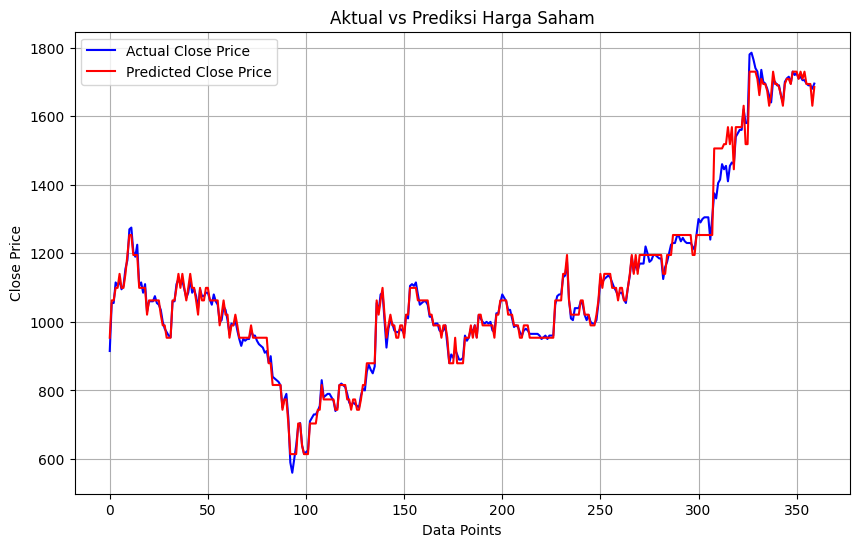

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame Pandas
dt_pred_pd = dt_predictions.select("Close", "prediction","Date").toPandas()

# Mengurutkan berdasarkan tanggal jika diperlukan
#dt_pred_pd.sort_values(by='Date', inplace=True)

# Plot harga saham aktual dan prediksi
plt.figure(figsize=(10, 6))
plt.plot(dt_pred_pd['Close'], label='Actual Close Price', color='blue')
plt.plot(dt_pred_pd['prediction'], label='Predicted Close Price', color='red')

plt.title('Aktual vs Prediksi Harga Saham')
plt.xlabel('Data Points')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

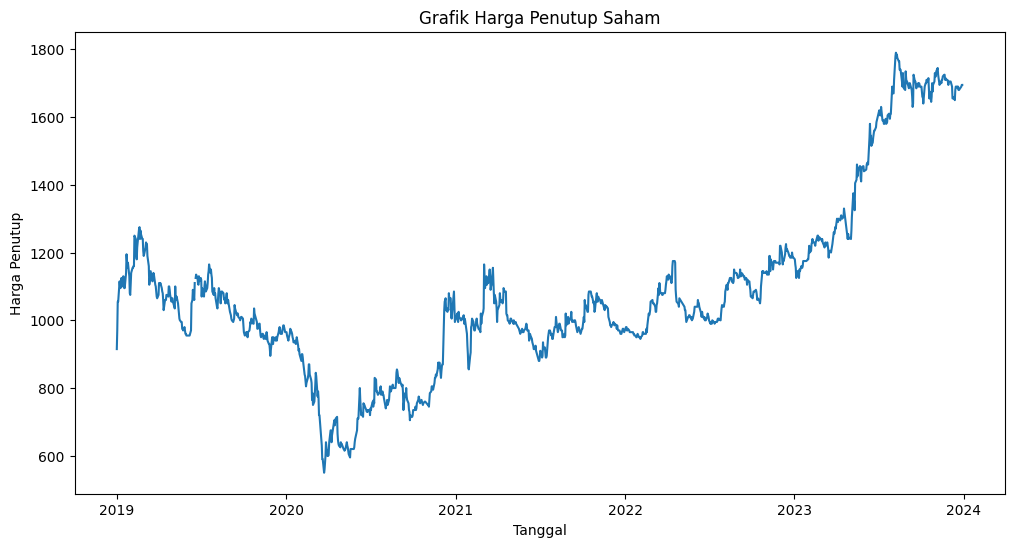

In [16]:
# Visualisasi candlestick chart menggunakan PySpark DataFrame
df = df.withColumn("Date", col("Date").cast("date"))
df_pd = df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['Close'])
plt.title('Grafik Harga Penutup Saham')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutup')
plt.show()

In [18]:
import pandas as pd

# Memuat data dari file CSV
df = pd.read_csv('BNGA.csv')

# Menampilkan beberapa baris pertama data untuk memastikan data terbaca dengan baik
print(df.head())


         Date    Open    High     Low   Close   Adj Close      Volume
0  2019-01-01   915.0   915.0   915.0   915.0  662.809998         0.0
1  2019-01-02   925.0   975.0   915.0   970.0  702.651001  23196500.0
2  2019-01-03   970.0  1075.0   970.0  1055.0  764.223450  42650800.0
3  2019-01-04  1060.0  1075.0  1025.0  1055.0  764.223450  10875900.0
4  2019-01-07  1055.0  1145.0  1055.0  1115.0  807.686462  25128600.0


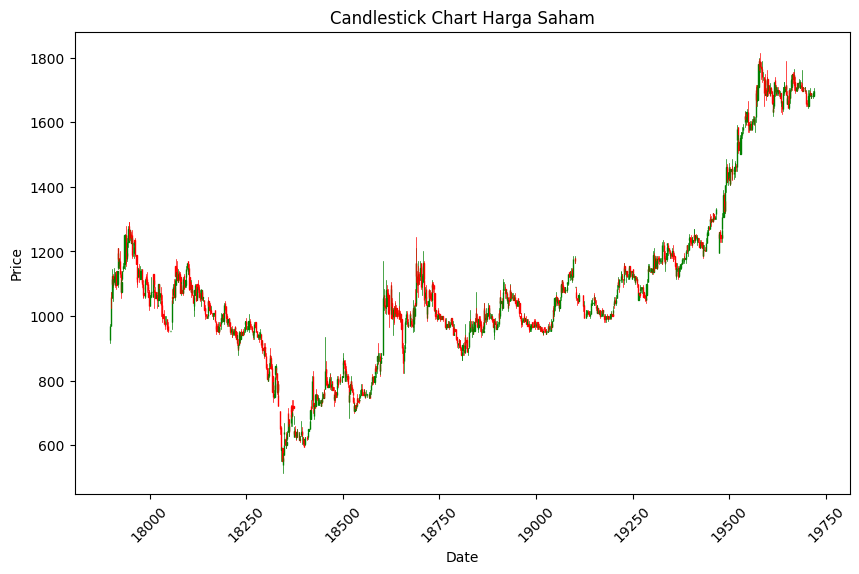

In [19]:
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Konversi kolom 'Date' ke dalam format yang sesuai untuk candlestick chart
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].apply(mdates.date2num)

# Menyiapkan data untuk candlestick chart (OHLC: Open, High, Low, Close)
ohlc_data = df[['Date', 'Open', 'High', 'Low', 'Close']].values

# Membuat plot candlestick chart
plt.figure(figsize=(10, 6))
candlestick_ohlc(plt.gca(), ohlc_data, width=0.6, colorup='green', colordown='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Candlestick Chart Harga Saham')
plt.xticks(rotation=45)
plt.show()
